In [35]:
import numpy as np
import matplotlib.pyplot as plt

from IPython import display
from scipy.io import loadmat
from skimage.util import view_as_windows

## FFT and IFFT

In [36]:
def fft(image, ax=(0, 1)):
    image = np.fft.ifftshift(image, axes=ax)
    kspace = np.fft.fft2(image, axes=ax)
    kspace = np.fft.fftshift(kspace, axes=ax)
    return kspace.astype(np.complex64)

def ifft(kspace, ax=(0, 1)):
    kspace = np.fft.ifftshift(kspace, axes=ax)
    image = np.fft.ifft2(kspace, axes=ax)
    image = np.fft.fftshift(image, axes=ax)
    return image.astype(np.complex64)

## Mask

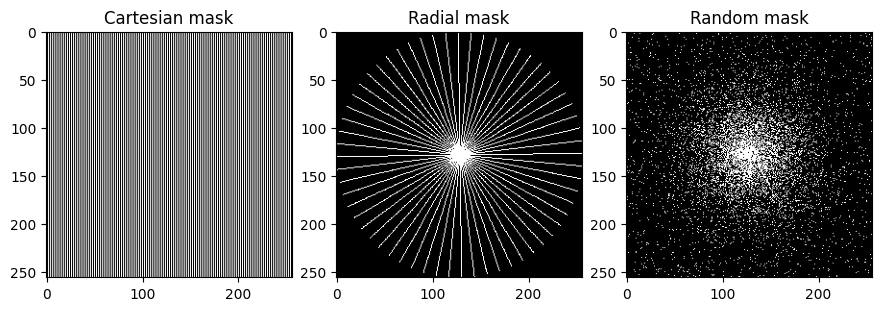

In [37]:
# load and present sampling mask
cart_mask_path = "./data/smapling_mask/mask_cart_050.mat"
radial_mask_path = "./data/smapling_mask/mask_radial_010.mat"
random_mask_path = "./data/smapling_mask/mask_random_010.mat"

cart_mask = loadmat(cart_mask_path)['mask_cart_050']
radial_mask = loadmat(radial_mask_path)['mask_radial_010']
random_mask = loadmat(random_mask_path)['mask_random_010']

fig, axes = plt.subplots(1, 3, layout='compressed', figsize=(9, 3))

axes[0].set_title('Cartesian mask')
axes[0].imshow(cart_mask, cmap='gray')

axes[1].set_title('Radial mask')
axes[1].imshow(radial_mask, cmap='gray')

axes[2].set_title('Random mask')
axes[2].imshow(random_mask, cmap='gray')

## Image and undersampled image

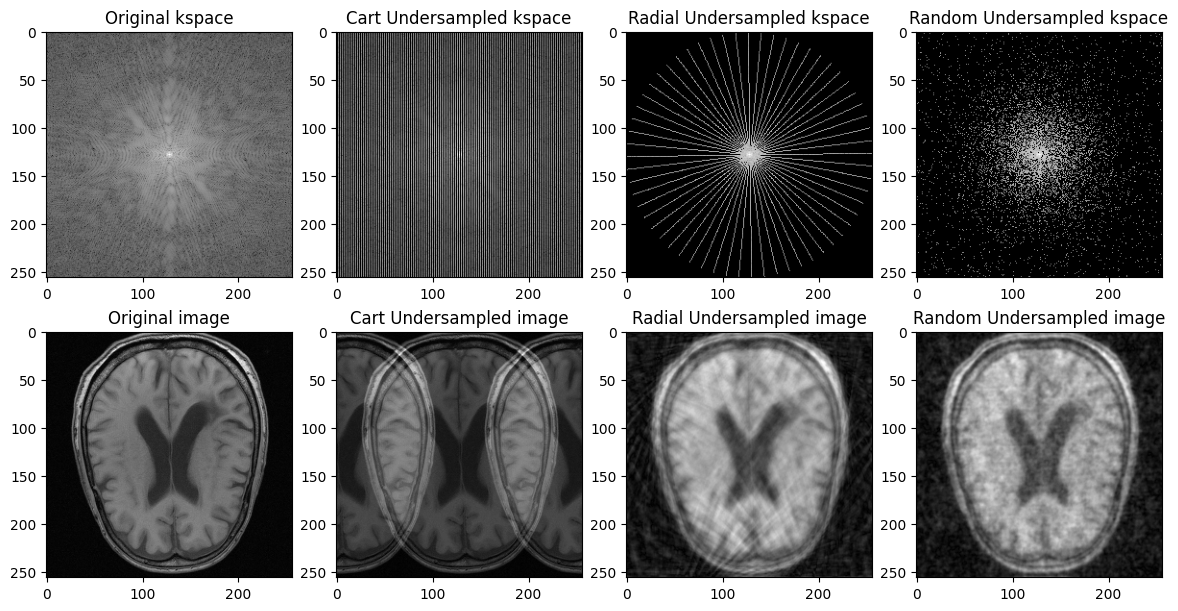

In [38]:
# load image, do undersampling and present
img_path = "./data/image_sos.mat"
img = loadmat(img_path)['DATA']
kspace = fft(img)

kspace_cart_masked = cart_mask * kspace
img_cart_masked = abs(ifft(kspace_cart_masked))

kspace_radial_masked = radial_mask * kspace
img_radial_masked = abs(ifft(kspace_radial_masked))

kspace_random_masked = random_mask * kspace
img_random_masked = abs(ifft(kspace_random_masked))

fig, axes = plt.subplots(2, 4, layout="compressed", figsize=(12, 6))

axes[0, 0].set_title('Original kspace')
axes[0, 0].imshow(np.log(abs(kspace)), cmap='gray')

axes[1, 0].set_title('Original image')
axes[1, 0].imshow(img, cmap='gray')

axes[0, 1].set_title('Cart Undersampled kspace')
axes[0, 1].imshow(np.log(abs(kspace_cart_masked)+1e-7), cmap='gray')

axes[1, 1].set_title('Cart Undersampled image')
axes[1, 1].imshow(img_cart_masked, cmap='gray')

axes[0, 2].set_title('Radial Undersampled kspace')
axes[0, 2].imshow(np.log(abs(kspace_radial_masked)+1e-7), cmap='gray')

axes[1, 2].set_title('Radial Undersampled image')
axes[1, 2].imshow(img_radial_masked, cmap='gray')

axes[0, 3].set_title('Random Undersampled kspace')
axes[0, 3].imshow(np.log(abs(kspace_random_masked)+1e-7), cmap='gray')

axes[1, 3].set_title('Random Undersampled image')
axes[1, 3].imshow(img_random_masked, cmap='gray')

## Coil sensitivity visualization

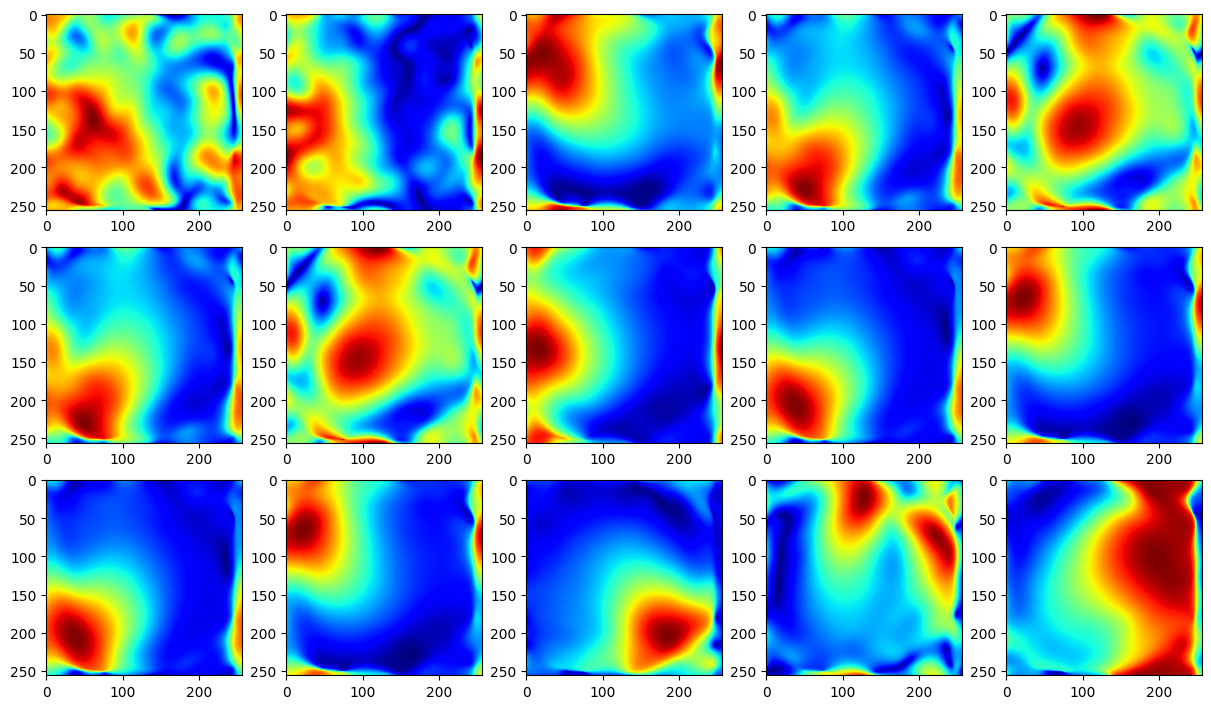

In [39]:
# load and present coil sensetivity
csm = loadmat( "./data/csm.mat")['DATA']
csm = np.transpose(csm, (1, 2, 0))
fig, axes = plt.subplots(3, 5, layout='compressed', figsize=(12, 8))
for i, row in enumerate(axes):
    for j, col in enumerate(axes[i]):
        axes[i, j].imshow(abs(csm)[..., 3*i + j], cmap='jet')

## Sensitivity weighted image

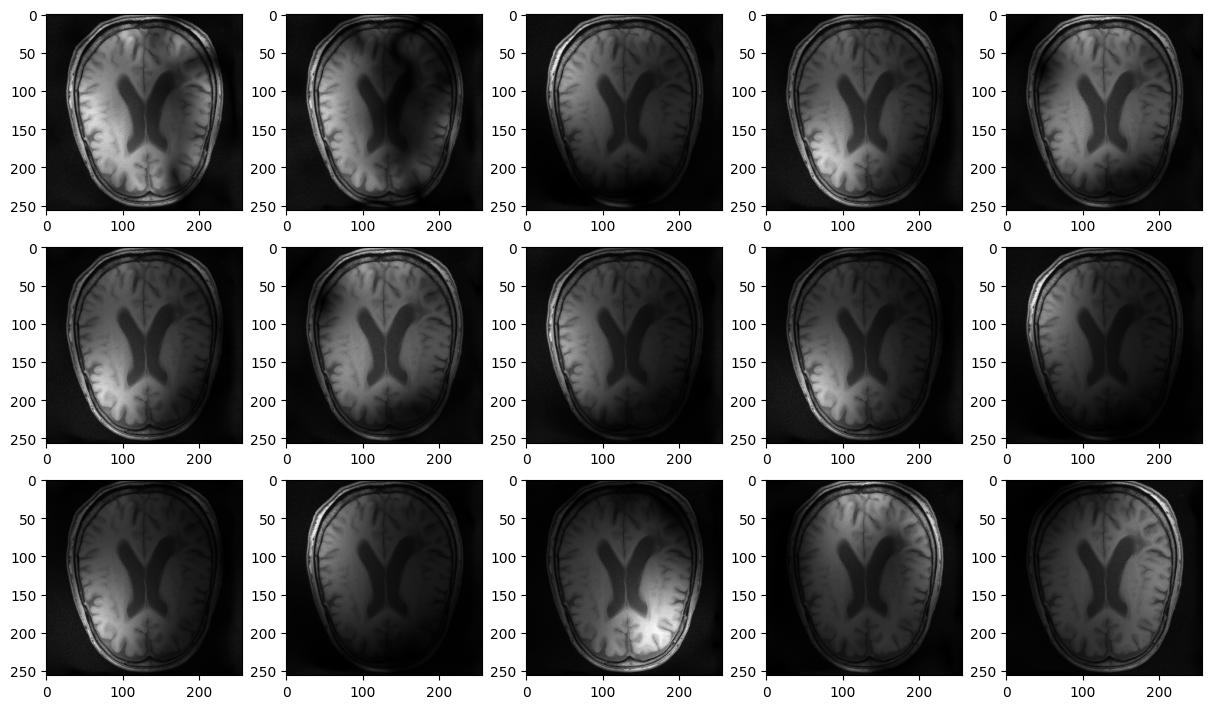

In [40]:
# present sensitivity weighted image
fig, axes = plt.subplots(3, 5, layout='compressed', figsize=(12, 8))
for i, row in enumerate(axes):
    for j, col in enumerate(axes[i]):
        axes[i, j].imshow(abs(csm * img[..., None])[..., 3*i + j], cmap='gray')

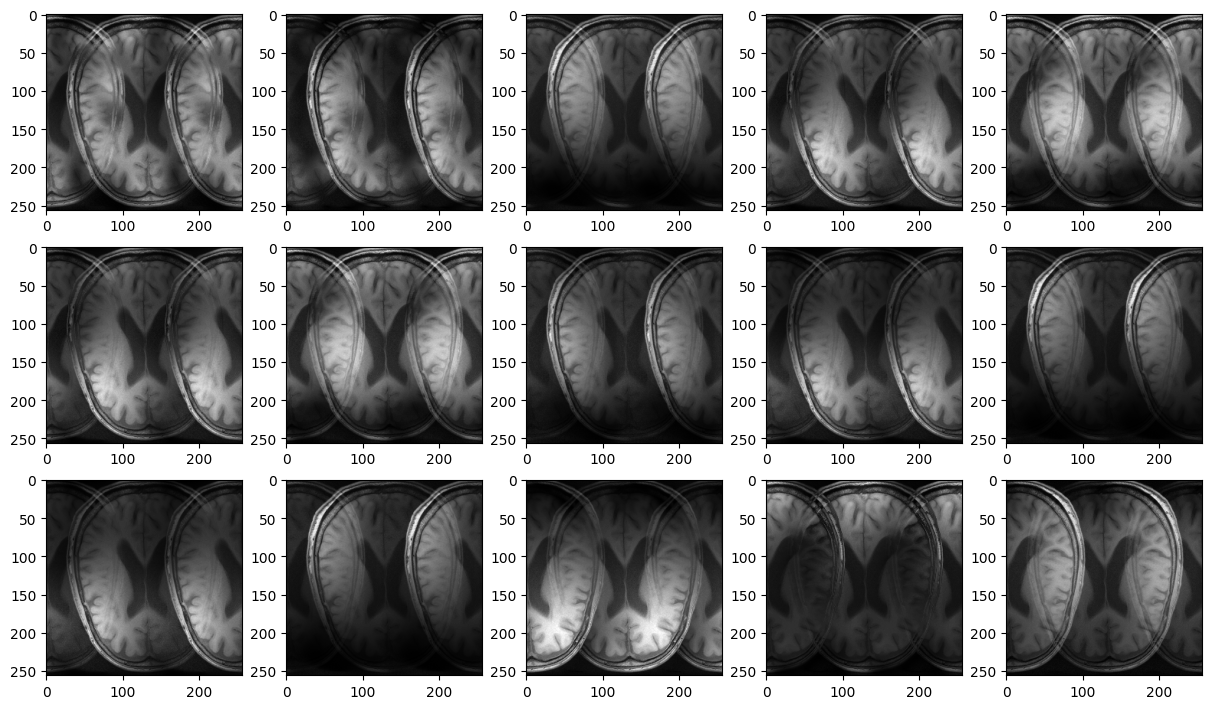

In [41]:
img_cart_masked_ncoil = ifft(cart_mask[..., None] * fft(csm * img[..., None]))
fig, axes = plt.subplots(3, 5, layout='compressed', figsize=(12, 8))
for i, row in enumerate(axes):
    for j, col in enumerate(axes[i]):
        axes[i, j].imshow(abs(img_cart_masked_ncoil)[..., 3*i + j], cmap='gray')

## SENSE

<Figure size 640x480 with 0 Axes>

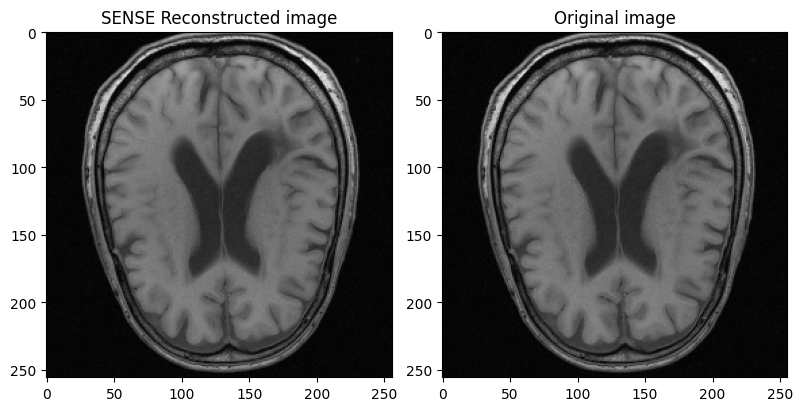

In [42]:
R = 2
H, W, C = img_cart_masked_ncoil.shape
recon_img = np.zeros((H, W), dtype=np.complex64)
for col in range(0, W//R):
    # select R positions in a row
    col_idxes = list(range(col, W, W//R))
    for row in range(0, H):
        # solve a sub-problem to get R pixels
        recon_img[row, col_idxes] = np.linalg.pinv(csm[row, col_idxes, :]).T @ img_cart_masked_ncoil[row, col, :]
        
    # visualize the reconstruction process
    if (col % 5 == 0 or col == H//R - 1): 
        plt.imshow(abs(recon_img), cmap='gray')
        display.display(plt.gcf())
        display.clear_output(wait=True)

plt.clf()

# compare results and original image
fig, axes = plt.subplots(1, 2, layout='compressed', figsize=(8, 4))
axes[0].set_title('SENSE Reconstructed image')
axes[0].imshow(abs(recon_img), cmap='gray')
axes[1].set_title('Original image')
axes[1].imshow(img, cmap='gray')

## GRAPPA

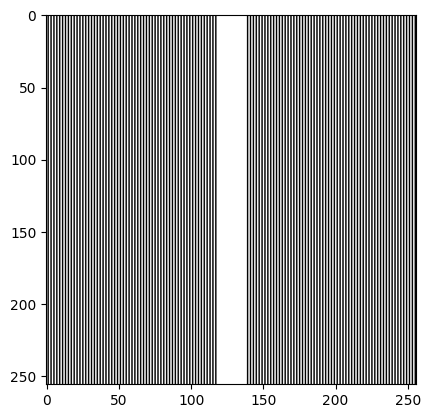

In [26]:
N = img.shape[0]
kspace_ncoil = fft(csm * img[..., None])
mask = np.zeros_like(kspace_ncoil, dtype=bool)
mask[:, ::2, :] = 1
ac_pad = 10
mask[:, N//2 - ac_pad: N//2 + ac_pad, :] = 1
plt.imshow(mask[..., 0], cmap="gray")

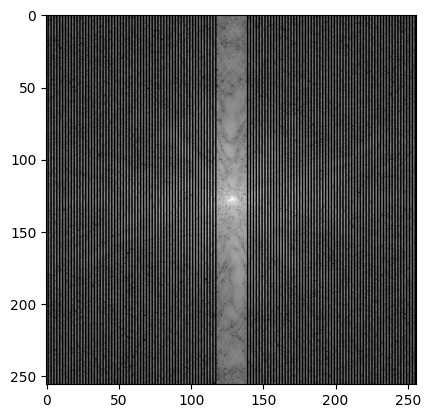

In [27]:
kspace_masked = kspace_ncoil * mask
plt.imshow(np.log(abs(kspace_masked[..., 0]) + 1e-7), cmap="gray")

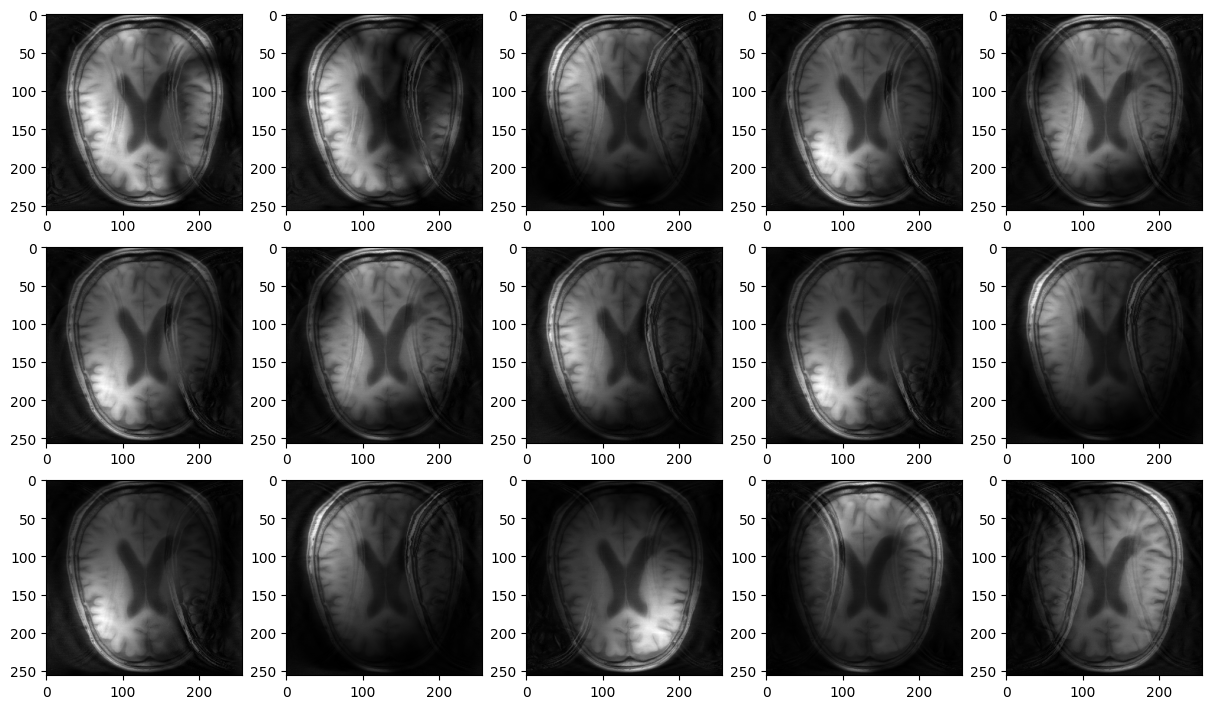

In [28]:
kspace_masked_ifft = ifft(kspace_masked)
fig, axes = plt.subplots(3, 5, layout='compressed', figsize=(12, 8))
for i, row in enumerate(axes):
    for j, col in enumerate(axes[i]):
        axes[i, j].imshow(abs(kspace_masked_ifft)[..., 3*i + j], cmap='gray')

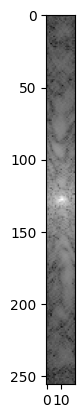

In [29]:
ac_region = kspace_masked[:, N//2 - ac_pad: N//2 + ac_pad, :]
plt.imshow(np.log(abs(ac_region[..., 0])+1e-7), cmap="gray")

In [30]:
kernel_size = [5, 5]
ncoils = 15
kx, ky = kernel_size
kspace_masked = np.pad(kspace_masked, ((kx//2, kx//2), (ky//2, ky//2), (0, 0)), mode='constant')
ac_region = np.pad(ac_region, ((kx//2, kx//2), (ky//2, ky//2), (0, 0)), mode='constant')
mask = np.pad(mask, ((kx//2, kx//2), (ky//2, ky//2), (0, 0)), mode='constant')

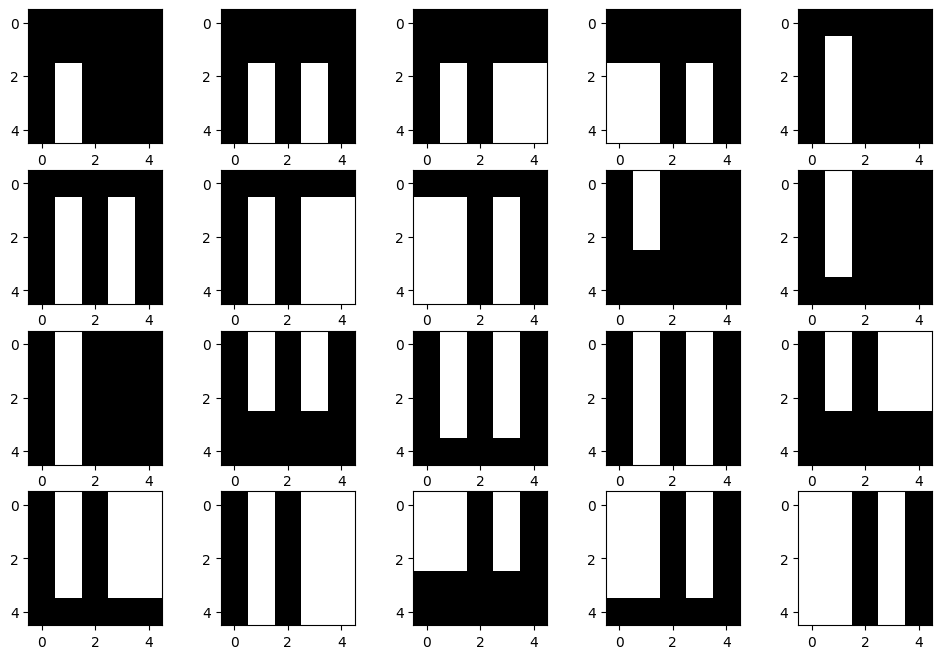

In [31]:
mask_patches = view_as_windows(mask[..., 0], kernel_size)
mask_patches = mask_patches.reshape((-1, kx, ky))
# Find the unique patches and associate them with indices
mask_patches, iidx = np.unique(mask_patches, return_inverse=True, axis=0)
# Filter out geometries that don't have a hole at the center.
# These are all the kernel geometries we actually need to compute weights for.
valid_index = np.argwhere(~mask_patches[:, kx//2, ky//2]).squeeze()
# visualize valid mask patches
fig, axes = plt.subplots(4, 5, figsize=(12, 8))
for i, axe in enumerate(axes.flatten()):
    axe.imshow(mask_patches[valid_index[i]], cmap="gray")

In [43]:
calib_patches = view_as_windows(ac_region, (kx, ky, ncoils)).reshape(-1, kx, ky, ncoils)

for valid_idx in valid_index:
    # Solve the equation for the weights:
    #  WS = T
    #  WSS^H = TS^H
    #  W = TS^H (SS^H)^-1
    mask_patch = mask_patches[valid_idx, ...]
    # Give mask_patch back its coil dimension
    mask_patch = np.tile(mask_patch[..., None], (1, 1, ncoils))
    source = calib_patches[:, mask_patch].T
    target = calib_patches[:, kx//2, ky//2, :].T
    TSh = target @ source.conj().T
    SSh = source @ source.conj().T
    weight = TSh @ np.linalg.pinv(SSh)

    # use fitted weight to predict missing kspace sample point
    idx = np.unravel_index(np.argwhere(iidx == valid_idx), (N, N))
    x, y = idx[0].flatten() + kx//2, idx[1].flatten() + ky//2
    for xx, yy in zip(x, y):
        source = kspace_masked[xx-kx//2: xx+kx//2+1, yy-ky//2: yy+ky//2+1]
        source = source[mask_patch]
        kspace_masked[xx, yy, :] = weight @ source


padded_size = kspace_masked.shape[0]
left = padded_size//2 - N//2
right = padded_size//2 + N//2
recon_kspace = kspace_masked[left: right, left:right,  :]

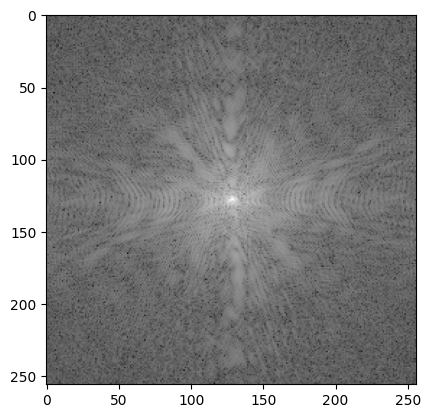

In [44]:
plt.imshow(np.log(abs(recon_kspace[..., 0])+1e-7), cmap="gray")

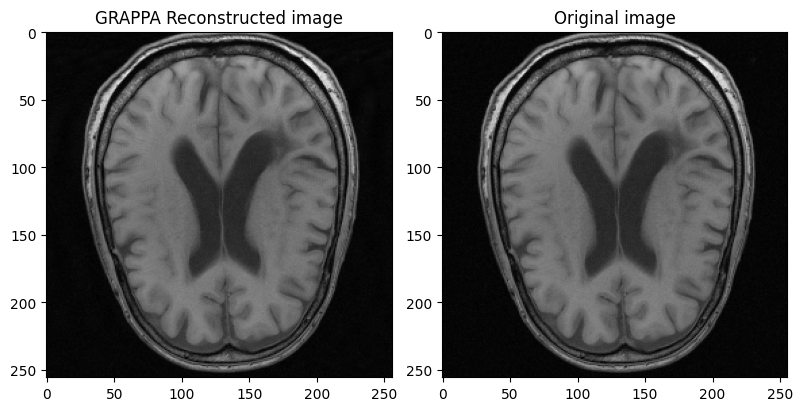

In [45]:
recon_img = abs(ifft(recon_kspace))
recon_img = np.sqrt((recon_img**2).sum(-1))

# compare results and original image
fig, axes = plt.subplots(1, 2, layout='compressed', figsize=(8, 4))
axes[0].set_title('GRAPPA Reconstructed image')
axes[0].imshow(abs(recon_img), cmap='gray')
axes[1].set_title('Original image')
axes[1].imshow(img, cmap='gray')